## Analysis of A/B test results and insight discovery

SollmaFin is an international mobile application for online trading of financial assets. Users can invest in stocks, currencies, cryptocurrencies, exchange-traded funds (ETFs), and other assets. The app’s target audience is beginner investors. Access to financial markets is available both via a mobile app and a web version.

The product is focused on the Latin American market, with particular emphasis on four countries: Mexico, Brazil, Colombia, and Argentina - regions where interest in fintech and investing is growing rapidly, while economic conditions vary significantly.

A hypothesis emerged that users have insufficient financial literacy and do not fully understand how to work with assets of different risk levels. As a result, many users invest in high-risk assets, incur losses, and subsequently reduce their engagement with the app. To address this issue, the product team decided to update the user onboarding by adding more detailed information about different types of financial assets and their associated risks. However, there was a concern that a more in-depth onboarding process might discourage users from depositing funds and making higher-risk investments.

To evaluate this trade-off, the team decided to run an A/B experiment.

### A/B Experiment

The experiment involved new users who registered in the app between June 2 and June 15, 2025.
Users were randomly split into two equal groups:

- Control group - users went through the standard onboarding without mandatory educational content.

- Test group - users went through the updated onboarding that included detailed information about asset types and associated risks.

After the split, user activity was tracked and analyzed for one week.

The goal of the experiment was to evaluate how the updated onboarding affects user behavior and subsequent investment activity.

When introducing the new feature, the product team formulated the following hypotheses:

- Growth hypothesis: educational onboarding helps users better understand investment principles, leading to a higher likelihood of opening a second deposit.

- Risk hypothesis: information about potential losses and high risks may discourage some newcomers—especially more cautious users—resulting in a lower conversion to the first deposit.

- Additional hypothesis: after the new onboarding, users who choose high-risk assets will return more often and open a second deposit compared to before. With the old onboarding, users frequently invested in high-risk assets without understanding the consequences, which led to losses and churn after the first deposit.

To capture the full picture, the team decided that tracking conversion metrics alone would not be sufficient. The following set of metrics was selected for the experiment:

- Primary metric - average total deposit amount per user (including users who only installed the app or opened the web version).

- Guardrail metric - conversion from registration to the first deposit.

- Secondary metric 1 - conversion from the first deposit to the second deposit.

- Secondary metric 2 - average total deposit amount per paying user (users who made at least one deposit).

It was expected that the primary and guardrail metrics would not decrease, while the secondary metrics would show significant growth.

### Analyst Tasks
1. Historical Data Analysis

- Analysis of new user behavior, including acquisition dynamics, segmentation, and key stages of the user funnel.

- Analysis of deposit-related metrics, including average deposit amounts.

2. A/B Test Data Analysis

- The analysis of the experiment results consists of two main stages:

- Comparison of user behavior between the control and test groups, including an assessment of the statistical significance of observed changes.

- Evaluation of the impact of the updated onboarding on the behavior of paying users.

### Data

The dataset /datasets/pa_sollmafin_hist.csv contains historical data on key actions of new users acquired between April 1 and June 1, 2025 (inclusive).
The dataset includes user actions up to the moment of making a second deposit.

The dataset /datasets/pa_sollmafin_abt.csv contains data from the A/B experiment - all actions of new users who registered between June 2 and June 15, 2025 (inclusive).
The data was collected to test the hypothesis about the impact of the new onboarding on user behavior and activity.
Users are already assigned to A/B test groups.

Common fields in both datasets:

- user_id - unique user identifier

- country_code - user country code in ISO format (e.g., BR - Brazil, MX - Mexico, AR - Argentina, CO - Colombia)

- platform - device used to interact with the product: mobile or web

- first_ts - timestamp of the user’s first appearance in the system

- first_dt - date of the user’s first appearance (without time)

- event_ts - event timestamp

- event_name - event name

- amount - deposit amount

- asset - type of purchased asset

- risk_level - asset risk level: low, medium, high

Additional fields in /datasets/pa_sollmafin_abt.csv:

- ab_test - A/B test name

* group - A/B test user group

### Project Plan

- Loading and preprocessing historical data

- Exploratory analysis of historical data

- Analysis of A/B test results

- Analysis of changes in deposit amounts per paying user

- Conclusions

---

### Part 1
#### 1. Loading and preprocessing data


In [1]:
# Importing libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta as td
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
from scipy import stats
import scipy.stats as stats
from scipy.stats import ttest_ind

In [2]:
# Loading the data

hist=pd.read_csv('https://code.s3.yandex.net/datasets/pa_sollmafin_hist.csv', parse_dates=['first_ts', 'first_dt', 'event_ts'])

In [3]:
# Reviewing dataframe information

print(hist.info())
print('\nUnique values:\n', hist.nunique())
print('\nSample rows:\n', hist.sample(3))
print('\nDuplicates count:', hist.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238059 entries, 0 to 238058
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       238059 non-null  object        
 1   country_code  238059 non-null  object        
 2   platform      238059 non-null  object        
 3   first_ts      238059 non-null  datetime64[ns]
 4   first_dt      238059 non-null  datetime64[ns]
 5   event_ts      238059 non-null  datetime64[ns]
 6   event_name    238059 non-null  object        
 7   amount        33093 non-null   float64       
 8   asset         15392 non-null   object        
 9   risk_level    15392 non-null   object        
dtypes: datetime64[ns](3), float64(1), object(6)
memory usage: 18.2+ MB
None

Unique values:
 user_id          41032
country_code         4
platform             2
first_ts         40830
first_dt            62
event_ts        232515
event_name           8
amount             291

**Interim conclusion**

The hist table with historical data contains 238,059 rows and 10 columns. No obvious duplicates or data type issues were identified.

- Object-type columns:
user_id (238,059), country_code (238,059), platform (238,059), event_name (230,859), asset (15,392), risk_level (15,392).

- Datetime columns (datetime64[ns]):
first_ts (230,859), first_dt (230,859), event_ts (230,859).

- Float column:
amount (33,093).

Further steps include checking for missing values and validating the logic and consistency of time-related fields.

In [4]:
# Checking missing values

hist.isna().sum()

user_id              0
country_code         0
platform             0
first_ts             0
first_dt             0
event_ts             0
event_name           0
amount          204966
asset           222667
risk_level      222667
dtype: int64

In [5]:
# Counting non-missing values by event type

summary = hist.groupby('event_name')[['amount', 'asset', 'risk_level']].apply(lambda x: x.notna().sum())
print(summary)

                     amount  asset  risk_level
event_name                                    
asset_purchase            0  15392       15392
first_deposit         27685      0           0
install / open_web        0      0           0
introduction              0      0           0
main_page                 0      0           0
onboarding_complete       0      0           0
registration              0      0           0
second_deposit         5408      0           0


**Interim conclusion**

- For the asset_purchase event, the asset and risk_level fields are always present, while amount is always NaN. This indicates that the deposit amount is not recorded at the asset purchase stage, even when a purchase occurs.

- For the first_deposit and second_deposit events, only the amount field is populated, while other fields related to assets and risk levels are missing.


In [6]:
# Rows with non-null amount
amounts = hist[hist['amount'].notna()]
print(f"Non-null amounts: {len(amounts)}")

# Zero amounts
zeros = amounts[amounts['amount'] == 0]
print(f" Zero amounts: {len(zeros)}")

# Negative amounts
negatives = amounts[amounts['amount'] < 0]
print(f"Negative amounts: {len(negatives)}")

# Overall statistics
print(amounts['amount'].describe())

# Very large amounts (above the 99th percentile)
high_threshold = amounts['amount'].quantile(0.99)
outliers = amounts[amounts['amount'] > high_threshold]
print(f"Very large amounts (>{high_threshold:.2f}): {len(outliers)}")

# Duplicates by user_id + event_ts + amount
duplicates = amounts.duplicated(subset=['user_id', 'event_ts', 'amount']).sum()
print(f"Potential duplicates: {duplicates}")


Non-null amounts: 33093
 Zero amounts: 0
Negative amounts: 0
count    33093.000000
mean       113.527967
std         34.472458
min         27.000000
25%         90.000000
50%        109.000000
75%        131.000000
max        524.000000
Name: amount, dtype: float64
Very large amounts (>222.00): 329
Potential duplicates: 0


In [7]:
# Checking correctness of timestamps (first_ts < event_ts)

invalid_time_order = hist[hist['first_ts'] > hist['event_ts']]
print(f"Events occurring before the user's first appearance in the system: {len(invalid_time_order)}")

Events occurring before the user's first appearance in the system: 0


**Interim conclusion**

The sequence of events is correct, no anomalies were found.

In [8]:
# Checking events within the expected time range
start_date = pd.Timestamp("2025-04-01")
end_date = pd.Timestamp("2025-06-01")

events_out_of_range = hist[~hist['event_ts'].between(start_date, end_date)]
print(f"Events outside the selected date range: {len(events_out_of_range)}")

Events outside the selected date range: 6111


**Interim conclusion**

Events outside the date range account for only 2.6% of the total and can be safely retained in the dataset.

In [9]:
pre_registration_events = hist[hist['event_ts'] < hist['first_ts']]
print(f"Events before user registration: {len(pre_registration_events)}")

Events before user registration: 0


In [10]:
categorical_cols = ['event_name', 'platform', 'country_code', 'asset', 'risk_level']

for col in categorical_cols:
    print(f"Unique values in categorical fields: {col}: {hist[col].unique()}")

Unique values in categorical fields: event_name: ['install / open_web' 'introduction' 'registration' 'main_page'
 'onboarding_complete' 'first_deposit' 'asset_purchase' 'second_deposit']
Unique values in categorical fields: platform: ['mobile' 'web']
Unique values in categorical fields: country_code: ['BR' 'AR' 'CO' 'MX']
Unique values in categorical fields: asset: [nan 'stock' 'option' 'crypto']
Unique values in categorical fields: risk_level: [nan 'medium' 'high' 'low']


**Interim conclusion**

Categorical features are clean and can be reliably used for segmentation.

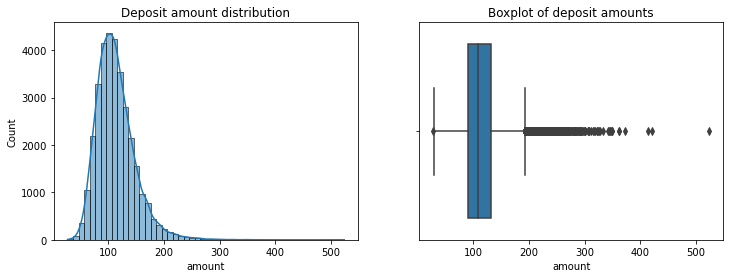

In [11]:
# Checking the distribution of deposit amounts and outliers

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(hist['amount'].dropna(), bins=50, kde=True)
plt.title('Deposit amount distribution')

plt.subplot(1,2,2)
sns.boxplot(x=hist['amount'].dropna())
plt.title('Boxplot of deposit amounts')
plt.show()

**Interim conclusion**

Most deposits are of relatively small amounts, concentrated around 100.
There are several large deposits that can be considered outliers, exceeding the 400 mark.

---
### 2. Exploratory analysis of historical data

#### 2.1. New users analysis

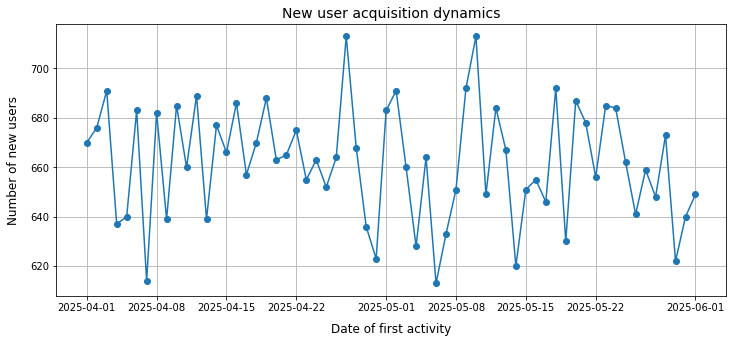

In [45]:
# Count new users by date
new_users = hist.groupby('first_dt')['user_id'].nunique().reset_index(name='new_users')

# Plot
plt.figure(figsize=(12,5))
plt.plot(new_users['first_dt'], new_users['new_users'], marker='o')
plt.title('New user acquisition dynamics', fontsize=14)
plt.xlabel('Date of first activity', fontsize=12, labelpad=10)
plt.ylabel('Number of new users', fontsize=12, labelpad=10)
plt.grid(True)
plt.show()

**Interim conclusion**

In the historical data, we observe highly volatile new user acquisition. The numbers fluctuate from 615 new users per day at the minimum to 715 at the maximum. After the peak on May 10, there is an overall downward trend.

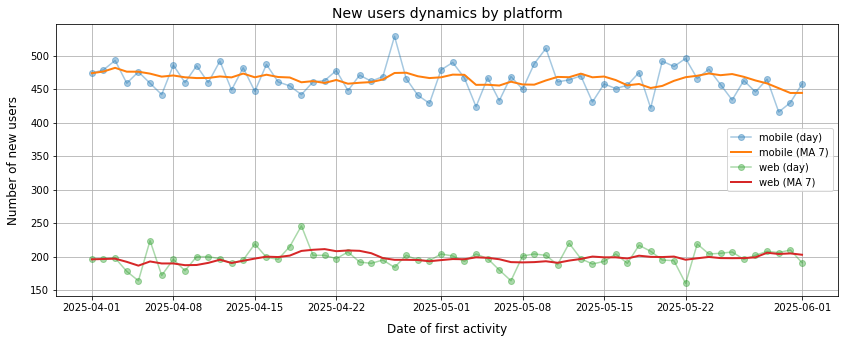

In [46]:
# Count new users by date and platform
new_users_platform = (
    hist.groupby(['first_dt', 'platform'])['user_id']
    .nunique()
    .reset_index(name='new_users')
)

pivot_platform = new_users_platform.pivot(index='first_dt', columns='platform', values='new_users').fillna(0)

# 7-day moving average
pivot_platform_ma = pivot_platform.rolling(window=7, min_periods=1).mean()

# Plot
plt.figure(figsize=(14,5))
for col in pivot_platform.columns:
    plt.plot(pivot_platform.index, pivot_platform[col], marker='o', alpha=0.4, label=f'{col} (day)')
    plt.plot(pivot_platform_ma.index, pivot_platform_ma[col], linewidth=2, label=f'{col} (MA 7)')

plt.title('New users dynamics by platform', fontsize=14)
plt.xlabel('Date of first activity', fontsize=12, labelpad=10)
plt.ylabel('Number of new users', fontsize=12, labelpad=10)
plt.legend()
plt.grid(True)
plt.show()

**Interim conclusion**

The mobile platform significantly outperforms the web in terms of new users. By the end of the period, activity on the mobile platform shows a decline.

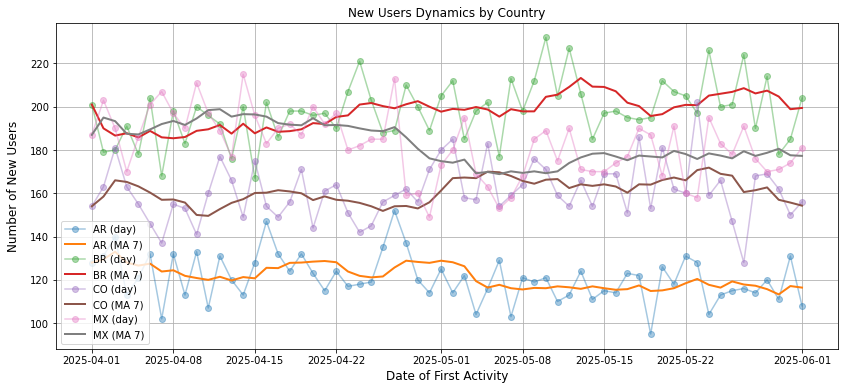

In [14]:
# By country
new_users_country = (
    hist.groupby(['first_dt', 'country_code'])['user_id']
    .nunique()
    .reset_index(name='new_users')
)
pivot_country = new_users_country.pivot(index='first_dt', columns='country_code', values='new_users').fillna(0)
pivot_country_ma = pivot_country.rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(14,6))
for col in pivot_country.columns:
    plt.plot(pivot_country.index, pivot_country[col], marker='o', alpha=0.4, label=f'{col} (day)')
    plt.plot(pivot_country_ma.index, pivot_country_ma[col], linewidth=2, label=f'{col} (MA 7)')

plt.title('New Users Dynamics by Country', fontsize=12)
plt.xlabel('Date of First Activity', fontsize=12)
plt.ylabel('Number of New Users', fontsize=12, labelpad=10)
plt.legend()
plt.grid(True)

**Interim conclusion**

The highest activity is observed in Brazil, especially in mid-May. Mexico shows the most stable dynamics with the least fluctuations. At the end of the period, there is a general decrease in activity across all countries.

#### 2.2 .Event funnel analysis

- Build classic and step-by-step funnels

- Characterize the user journey in the app and identify funnel bottlenecks

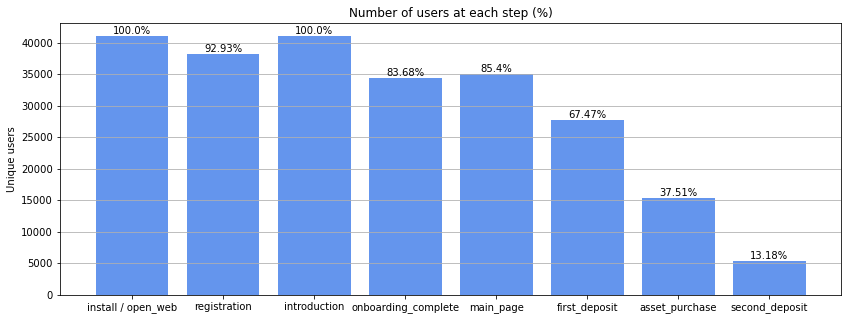

In [47]:
# Build classic funnel

# Filter events
funnel_steps = ['install / open_web','registration', 'introduction','onboarding_complete', 'main_page',  'first_deposit', 'asset_purchase', 'second_deposit']
funnel_df = hist[hist['event_name'].isin(funnel_steps)]

# Group by step and count unique users
funnel_counts = funnel_df.groupby('event_name')['user_id'].nunique().reindex(funnel_steps).reset_index()
funnel_counts = funnel_counts.rename(columns={'user_id': 'user_n'})

# Calculate conversion
funnel_counts['conversion_from_start_%'] = (funnel_counts['user_n'] / funnel_counts['user_n'].iloc[0] * 100).round(2)

# Plot the graf
plt.figure(figsize=(14,5))
bars = plt.bar(funnel_counts['event_name'], funnel_counts['user_n'], color='cornflowerblue')
plt.title('Number of users at each step (%)')
plt.ylabel('Unique users')
plt.grid(axis='y')

for bar, pct in zip(bars, funnel_counts['conversion_from_start_%']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{pct}%',
             ha='center', va='bottom', fontsize=10)
plt.show()

**Interim conclusion**

- In the classic user journey funnel, the registration step is not mandatory, as we see 100% of users on the introduction step, while only about 93% reach the registration step.

- Next, there is another deviation from the standard user flow - 1.72% more users reach the main page than complete onboarding. This could indicate that the onboarding completion criterion is unclear, users can access the dashboard directly, or data from product testing is recorded.

- Overall, only about 13% of users make a second deposit, while 67.5% make the first deposit. This gap may indicate a poor asset management experience.

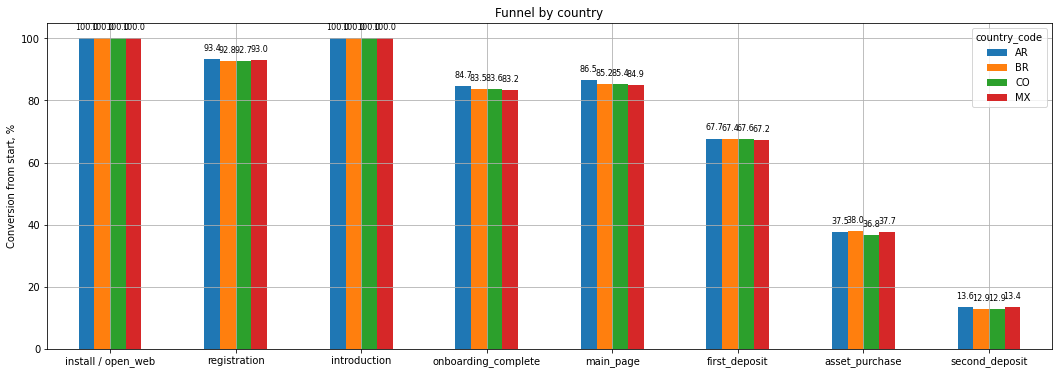

In [48]:
# Build funnel by country

# Funnel steps
funnel_steps = ['install / open_web','registration','introduction','onboarding_complete',
                'main_page','first_deposit','asset_purchase','second_deposit']

# Filter events
funnel_df = hist[hist['event_name'].isin(funnel_steps)]

# Group by country and step, count unique users
funnel_country = funnel_df.groupby(['country_code', 'event_name'])['user_id'].nunique().reset_index()

# Calculate conversion from start for each country
funnel_country = funnel_country.merge(
    funnel_country[funnel_country['event_name'] == funnel_steps[0]][['country_code', 'user_id']],
    on='country_code', suffixes=('', '_start'))
funnel_country['conversion_%'] = funnel_country['user_id'] / funnel_country['user_id_start']*100

pivot_df = funnel_country.pivot(index='event_name', columns='country_code', values='conversion_%').reindex(funnel_steps)

# Plot
ax = pivot_df.plot(kind='bar', figsize=(18,6), grid=True, title='Funnel by country')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, 
            p.get_height() + (ax.get_ylim()[1]*0.02),
            f'{p.get_height():.1f}',
            ha='center', va='bottom', fontsize=8)
    
plt.xticks(rotation=0, ha='center')
plt.ylabel('Conversion from start, %')
plt.xlabel('')
plt.show()

**Interim cocnclusion**

No significant differences are observed across countries.

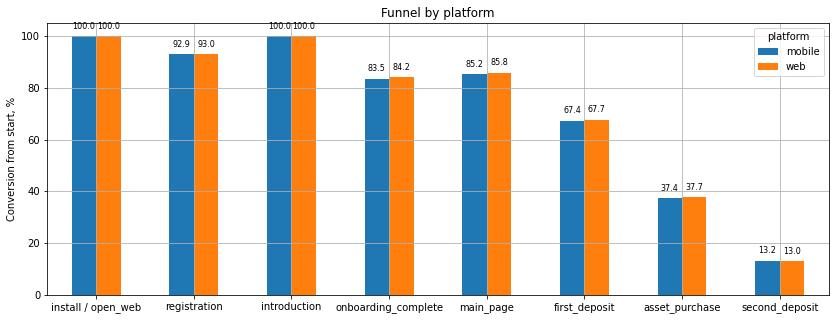

In [49]:
# Build funnel by platform

# Funnel steps
funnel_steps = ['install / open_web','registration','introduction','onboarding_complete',
                'main_page','first_deposit','asset_purchase','second_deposit']

# Filter events
funnel_df = hist[hist['event_name'].isin(funnel_steps)]

# Group by platform and step, count unique users
funnel_platform = funnel_df.groupby(['platform', 'event_name'])['user_id'].nunique().reset_index()

# Calculate conversion from start for each platform
funnel_platform = funnel_platform.merge(
    funnel_platform[funnel_platform['event_name'] == funnel_steps[0]][['platform', 'user_id']],
    on='platform', suffixes=('', '_start'))
funnel_platform['conversion_%'] = funnel_platform['user_id'] / funnel_platform['user_id_start']*100

pivot_df = funnel_platform.pivot(index='event_name', columns='platform', values='conversion_%').reindex(funnel_steps)

# Plot
ax = pivot_df.plot(kind='bar', figsize=(14,5), grid=True, title='Funnel by platform')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, 
            p.get_height() + (ax.get_ylim()[1]*0.02),
            f'{p.get_height():.1f}',
            ha='center', va='bottom', fontsize=8)
    
plt.xticks(rotation=0, ha='center')
plt.ylabel('Conversion from start, %')
plt.xlabel('')
plt.show()

**Interim ocnclusion**

No significant differences are observed between platforms.

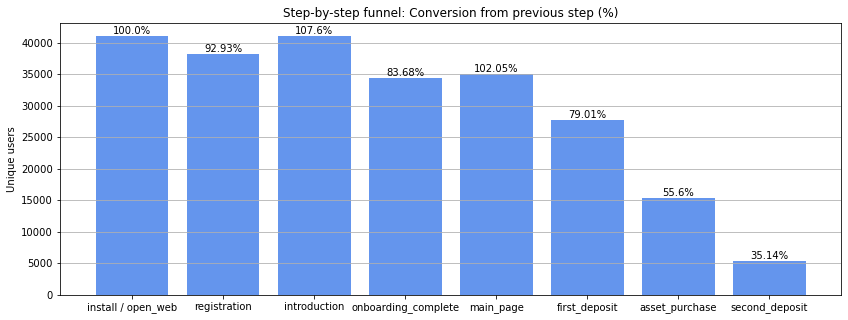

In [50]:
# Build step-by-step funnel

# Filter funnel steps
funnel_steps = ['install / open_web','registration', 'introduction', 'onboarding_complete', 'main_page', 'first_deposit', 'asset_purchase', 'second_deposit']
funnel_df = hist[hist['event_name'].isin(funnel_steps)]

# Group by step and count unique users
funnel_counts = funnel_df.groupby('event_name')['user_id'].nunique().reindex(funnel_steps).reset_index()
funnel_counts = funnel_counts.rename(columns={'user_id': 'user_n'})

# Calculate step-to-step conversion
funnel_counts['conversion_from_prev_%'] = (funnel_counts['user_n'] / funnel_counts['user_n'].shift(1) * 100).round(2)
funnel_counts.loc[0, 'conversion_from_prev_%'] = 100

# Plot the chart
plt.figure(figsize=(14,5))
bars = plt.bar(funnel_counts['event_name'], funnel_counts['user_n'], color='cornflowerblue')
plt.title('Step-by-step funnel: Conversion from previous step (%)')
plt.ylabel('Unique users')
plt.grid(axis='y')

for bar, pct in zip(bars, funnel_counts['conversion_from_prev_%']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{pct}%',
             ha='center', va='bottom', fontsize=10)
plt.show()

**Interim conclusion**

We observe that only 55.6% of users who made their first deposit proceed to purchase an asset. This may indicate insufficient transparency of the purchase process or a lack of information at this stage.

Additionally, only 35% of users who completed an asset purchase go on to make a second deposit, highlighting a significant drop in engagement after the first investment experience.

#### 2.3. Impact of asset risk level on second deposit conversion

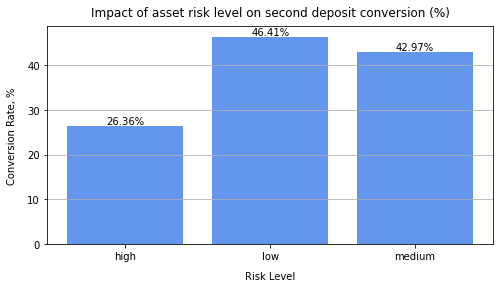

In [19]:
# Extract risk level from asset_purchase event
risk_df = hist[hist['event_name'] == 'asset_purchase'][['user_id', 'risk_level']]

# Get users who made a second deposit
second_deposit_users = hist[hist['event_name'] == 'second_deposit']['user_id'].unique()

# Get users with first deposit
first = hist[hist['event_name'] == 'first_deposit'][['user_id']]

# Merge with risk level
first = first.merge(risk_df, on='user_id', how='left')

# Flag second deposit
first['second_deposit'] = first['user_id'].isin(second_deposit_users).astype(int)

# Conversion by risk level
conversion = first.groupby('risk_level')['second_deposit'].mean().mul(100).reset_index().round(2)

# Plot
plt.figure(figsize=(8,4))
bars = plt.bar(conversion['risk_level'].astype(str), conversion['second_deposit'], color='cornflowerblue')
plt.title('Impact of asset risk level on second deposit conversion (%)', pad=10)
plt.ylabel('Conversion Rate, %', labelpad=10)
plt.xlabel('Risk Level', labelpad=10)
plt.grid(axis='y')

for bar, pct in zip(bars, conversion['second_deposit']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{pct}%',
             ha='center', va='bottom', fontsize=10)
plt.show()

**Interim conclusion**

Only 26% of users who purchased high-risk assets proceed to open a second deposit.
For medium-risk assets, the second deposit is made in 43% of cases, while for low-risk assets this figure reaches 46%.
This indicates that insufficient awareness of risks leads to a rapid loss of interest in the product among new users who start with high-risk assets and are likely to experience losses early on.

#### 2.4. Key metric analysis on historical data


In [20]:
# Total number of users
total_users = hist['user_id'].nunique()

# Total deposit amount per user
user_deposits = hist.groupby('user_id')['amount'].sum().fillna(0)

# Average deposit amount per user
avg_deposit_per_user = user_deposits.sum() / total_users
print(f" Average deposit amount per user: {avg_deposit_per_user:.2f}")

 Average deposit amount per user: 91.56


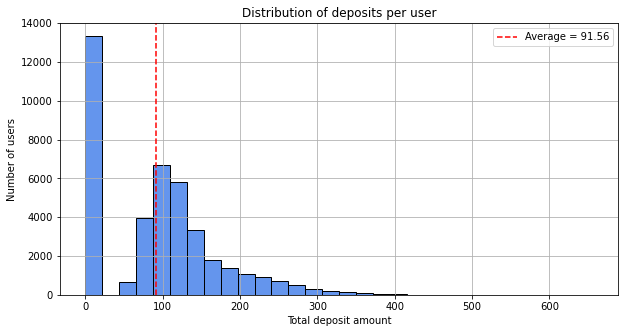

In [21]:
# Distribution of deposits per user

plt.figure(figsize=(10,5))
plt.hist(user_deposits, bins=30, color='cornflowerblue', edgecolor='black')
plt.axvline(avg_deposit_per_user, color='red', linestyle='--', label=f'Average = {avg_deposit_per_user:.2f}')
plt.title('Distribution of deposits per user')
plt.xlabel('Total deposit amount')
plt.ylabel('Number of users')
plt.legend()
plt.grid(True)
plt.show()

**Interim conclusion**

The distribution shows a strong right skew with a long tail. Most users have very small or zero deposit amounts, while a small number of “whales” contribute large sums and pull the average upward.
The baseline average monetization across all users is 91.56.

In [22]:
# Standard deviation
std_deposit_per_user = user_deposits.std()

print(f"Average deposit amount per user: {avg_deposit_per_user:.2f}")
print(f"Standard deviation: {std_deposit_per_user:.2f}")


Average deposit amount per user: 91.56
Standard deviation: 80.39


**Interim conclusion**

The standard deviation is almost equal to the mean, indicating high variability in user deposits. A large share of users have deposits close to zero, while others contribute very high amounts.

With such high variance, the mean becomes unstable. Therefore, in A/B test analysis, relying solely on the average does not provide a complete picture. To properly evaluate experiment results, it is recommended to additionally analyze medians and percentiles.

---

### Part 2

####  3. A/B Experiment results analysis

In [23]:
# Load the data

abt = pd.read_csv('https://code.s3.yandex.net/datasets/pa_sollmafin_abt.csv', parse_dates=['first_ts', 'first_dt', 'event_ts'])

In [24]:
# Inspect dataframe information

print(abt.info())
print('\nUnique values:\n', abt.nunique())
print('\nSample rows:\n', abt.sample(3))
print('\nMissing values:\n', abt.isna().sum())
print('\nDuplicates count:', abt.duplicated().sum())
print('=' * 40)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54805 entries, 0 to 54804
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       54805 non-null  object        
 1   country_code  54805 non-null  object        
 2   platform      54805 non-null  object        
 3   first_ts      54805 non-null  datetime64[ns]
 4   first_dt      54805 non-null  datetime64[ns]
 5   event_ts      54805 non-null  datetime64[ns]
 6   event_name    54805 non-null  object        
 7   ab_test       54805 non-null  object        
 8   group         54805 non-null  object        
 9   amount        7843 non-null   float64       
 10  asset         3750 non-null   object        
 11  risk_level    3750 non-null   object        
dtypes: datetime64[ns](3), float64(1), object(8)
memory usage: 5.0+ MB
None

Unique values:
 user_id          9415
country_code        4
platform            2
first_ts         9371
first_dt  

**Interim conclusion**

The abt table with test data contains 54,805 rows and 11 columns.
No obvious duplicates or data type issues were detected.
- Object columns:
user_id (54,805), country_code (54,805), platform (54,805),
event_name (54,805), ab_test (54,805), group (54,805),
asset (3,750), risk_level (3,750)
- Datetime columns (datetime64[ns]):
first_ts (54,805), first_dt (54,805), event_ts (54,805)
- Float column:
amount (7,843)

#### 3.1. Experiment audience analysis


In [25]:
# Check user distribution across groups
user_distribution = abt.groupby('group')['user_id'].nunique().reset_index()
user_distribution.rename(columns={'user_id': 'unique_users'}, inplace=True)

print(user_distribution)

     group  unique_users
0  control          4847
1     test          4568


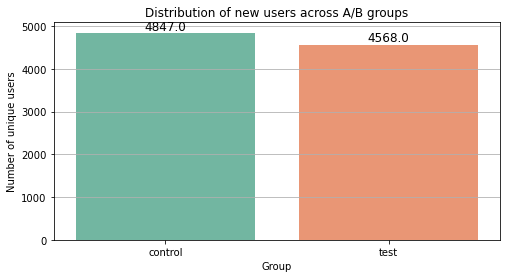

In [26]:
# Visualize distribution
plt.figure(figsize=(8,4))
barplot = sns.barplot(x='group', y='unique_users', data=user_distribution, palette='Set2')

for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height}', 
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom', fontsize=12, color='black')
    
plt.title('Distribution of new users across A/B groups')
plt.ylabel('Number of unique users')
plt.xlabel('Group')
plt.grid(axis='y')
plt.show()

**Interim conclusion**

The difference between the groups is 279 users.
The control group is larger than the test group by 5.9%, which is an acceptable deviation.

In [27]:
# Check for user overlap between groups
users_A = set(abt.loc[abt['group'] == 'control', 'user_id'])
users_B = set(abt.loc[abt['group'] == 'test', 'user_id'])

overlap = users_A.intersection(users_B)

print(f"Users assigned to both groups: {len(overlap)}")


Users assigned to both groups: 0


**Interim conclusion**

No user overlap between the experiment groups was detected.

#### 3.2. Event funnel comparison


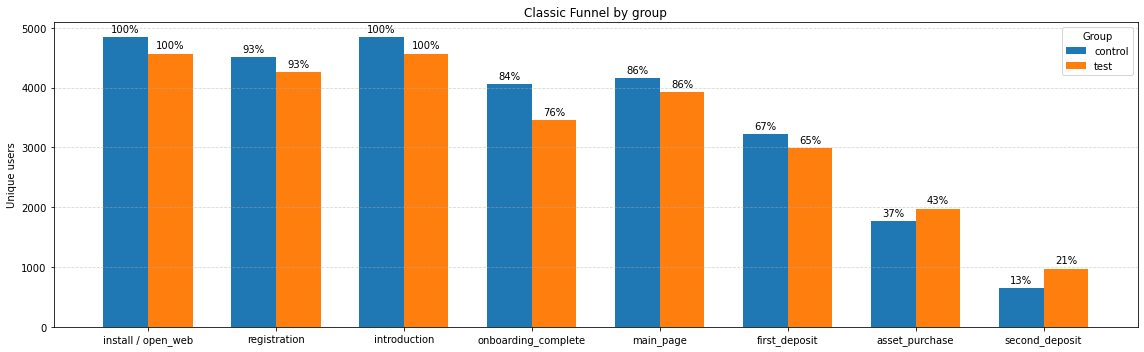

In [28]:
# Funnel steps
funnel_steps = ['install / open_web','registration','introduction','onboarding_complete',
                'main_page','first_deposit','asset_purchase','second_deposit']

# Filter funnel steps
funnel_df = abt[abt['event_name'].isin(funnel_steps)].copy()
funnel_df['event_name'] = pd.Categorical(funnel_df['event_name'], categories=funnel_steps, ordered=True)

# Unique users by step and group
funnel_counts = funnel_df.groupby(['group','event_name'])['user_id'].nunique().reset_index()

# Conversion from start
funnel_counts['conversion_%'] = funnel_counts.groupby('group')['user_id']\
                                             .transform(lambda x: x / x.iloc[0] * 100)

# Plot
groups = funnel_counts['group'].unique()
x = range(len(funnel_steps))
width = 0.35

plt.figure(figsize=(16,5))
for i, group in enumerate(groups):
    vals = funnel_counts[funnel_counts['group']==group]['user_id'].values
    plt.bar([p + i*width for p in x], vals, width=width, label=group)


for i, row in funnel_counts.iterrows():
    x_pos = x[funnel_steps.index(row['event_name'])] + (0 if row['group']=='control' else width)
    plt.text(x_pos, row['user_id'] + 50, f"{row['conversion_%']:.0f}%", 
             ha='center', va='bottom', fontsize=10)

plt.xticks([p + width/2 for p in x], funnel_steps)
plt.ylabel('Unique users')
plt.title('Classic Funnel by group')
plt.legend(title='Group')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Interim conclusion**

Clear behavioral differences between the groups can be observed.
In the control group, 84% of users complete onboarding, which is 8 percentage points higher than in the test group. This may be related to increased complexity or difficulty of the new onboarding flow.

However, the share of users reaching the main page is the same for both groups (86% of app openers).
The control group shows a 2% higher first-deposit rate, but the purchase rate is higher in the test group - 43% vs. 37%. This suggests that the new onboarding feature has a positive impact.

User retention is also stronger in the test group: 21% of users make a second deposit compared to 13% in the control group.

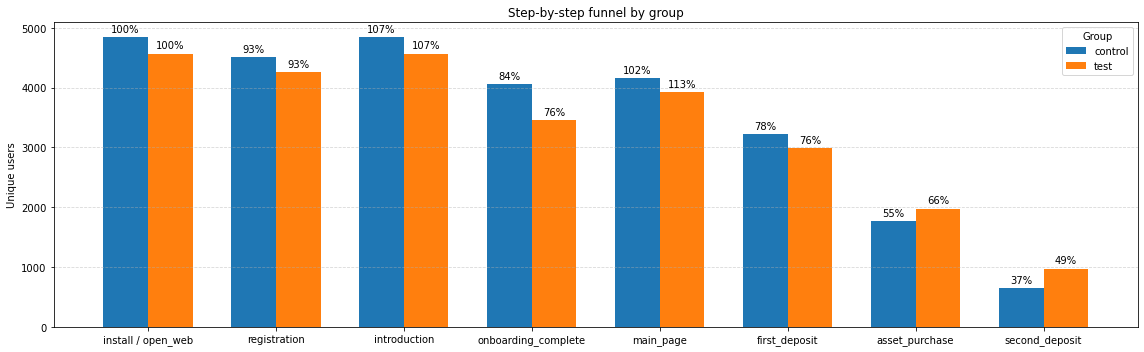

In [29]:
# Build step-by-step funnel

# Funnel steps
funnel_steps = ['install / open_web','registration','introduction','onboarding_complete',
                'main_page','first_deposit','asset_purchase','second_deposit']

# Filter funnel steps
funnel_df = abt[abt['event_name'].isin(funnel_steps)].copy()
funnel_df['event_name'] = pd.Categorical(funnel_df['event_name'], categories=funnel_steps, ordered=True)

# Unique users by step and group
funnel_counts = funnel_df.groupby(['group','event_name'])['user_id'].nunique().reset_index()

# Step-to-step conversion
funnel_counts['prev_conversion_%'] = funnel_counts.groupby('group')['user_id']\
                                                    .apply(lambda x: x.div(x.shift(1)).fillna(1)*100)

# Plot
groups = funnel_counts['group'].unique()
x = range(len(funnel_steps))
width = 0.35

plt.figure(figsize=(16,5))
for i, group in enumerate(groups):
    vals = funnel_counts[funnel_counts['group']==group]['user_id'].values
    plt.bar([p + i*width for p in x], vals, width=width, label=group)

for i, row in funnel_counts.iterrows():
    plt.text(x_pos := x[funnel_steps.index(row['event_name'])] + (0 if row['group']=='control' else width),
             row['user_id'] + 50, f"{row['prev_conversion_%']:.0f}%", ha='center', va='bottom', fontsize=10)

plt.xticks([p + width/2 for p in x], funnel_steps)
plt.ylabel('Unique users')
plt.title('Step-by-step funnel by group')
plt.legend(title='Group')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Interim conclusion**

The step-by-step funnel highlights a substantial difference at the purchase stage.
66% of test group users who made a first deposit proceed to purchase an asset, which is 11 percentage points higher than in the control group (55%).

The test group also demonstrates stronger continued engagement: 49% of users who made a purchase go on to make a second deposit, compared to 37% in the control group.

#### 3.3. Impact of the new feature on second deposit conversion by asset risk level

In [30]:
# Filter asset purchases with known risk level
assets = (abt[(abt['event_name'] == 'asset_purchase') & (abt['risk_level'].notna())][['user_id', 'group', 'risk_level']]
    .drop_duplicates()
)

# Second deposit flag
second_deposit_users = abt.loc[abt['event_name'] == 'second_deposit', 'user_id'].unique()
assets['second_deposit'] = assets['user_id'].isin(second_deposit_users).astype(int)

# Conversion rates
conv_table = (assets.groupby(['group', 'risk_level'])['second_deposit'].agg(conversion_rate='mean', n_users='count')
              .reset_index()
)

conv_table['conversion_rate'] = (conv_table['conversion_rate'] * 100).round(2)

print("Conversion rates by group and risk level")
print(conv_table)

Conversion rates by group and risk level
     group risk_level  conversion_rate  n_users
0  control       high            27.66      893
1  control        low            49.82      285
2  control     medium            44.54      595
3     test       high            46.00      737
4     test        low            57.46      496
5     test     medium            47.04      744


**Interim conclusion**

Clear differences in conversion rates between the groups can be observed.
However, it is necessary to determine whether these differences are statistically significant.

**Statistical hypotheses**

- H₀ (null hypothesis):
The probability of making a second deposit is the same across groups.

- H₁ (alternative hypothesis):
The probability of making a second deposit differs between groups.

In [31]:
# Apply chi-square test
for risk in assets['risk_level'].unique():
    contingency = pd.crosstab(
        assets.loc[assets['risk_level'] == risk, 'group'],
        assets.loc[assets['risk_level'] == risk, 'second_deposit']
    )
    chi2, p, _, _ = chi2_contingency(contingency)
    
    result = (
        "< 0.05. Reject H₀, statistically significant difference detected"
        if p < 0.05
        else "≥ 0.05. Fail to reject H₀, no statistically significant difference")
    
    print(f"Risk level: {risk} — p-value = {p:.4f}, conclusion: {result}")

Risk level: high — p-value = 0.0000, conclusion: < 0.05. Reject H₀, statistically significant difference detected
Risk level: low — p-value = 0.0467, conclusion: < 0.05. Reject H₀, statistically significant difference detected
Risk level: medium — p-value = 0.3904, conclusion: ≥ 0.05. Fail to reject H₀, no statistically significant difference


**Interim conclusion**

The statistical test results show that for high-risk and low-risk assets, there is a statistically significant difference in second deposit conversion between the control and test groups.

For medium-risk assets, no statistically significant difference is observed between the groups.

#### 3.4. A/B Experiment metrics analysis

We analyze the following metrics:

- Primary metric — average total deposit amount per user (including users who only installed the app or opened the web version).

- Guardrail metric — conversion from registration to first deposit.

- Supporting metric 1 — conversion from first deposit to second deposit.

- Supporting metric 2 — average total deposit amount per user who made at least one deposit.

After that, we test the statistical significance of metric differences between the experiment groups.

For the primary metric, we additionally analyze: cumulative dynamics over experiment days for each group, p-value stability during the experiment.

**ARPU - primary metric**

In [32]:
# Total deposit amount per user
deposits = abt.query("event_name in ['first_deposit', 'second_deposit']")[['user_id', 'group', 'event_name', 'amount', 'event_ts']]
user_deposits = deposits.groupby(['user_id', 'group'], as_index=False)['amount'].sum()

# Merge with all users (including those with zero deposits)
all_users = abt[['user_id', 'group']].drop_duplicates()
user_deposits = all_users.merge(user_deposits, on=['user_id', 'group'], how='left').fillna(0)

# ARPU
arpu = user_deposits.groupby('group')['amount'].mean().reset_index()
arpu.columns = ['group', 'ARPU']
print(arpu)

     group       ARPU
0  control  90.240149
1     test  92.460814


In [33]:
# ARPU by group

control_arpu = arpu.query("group == 'control'")['ARPU'].values[0]
test_arpu = arpu.query("group == 'test'")['ARPU'].values[0]

absolute_diff = test_arpu - control_arpu
relative_diff = absolute_diff / control_arpu*100

print(f"Absolute change: {absolute_diff:.2f}")
print(f"Relative change: {relative_diff:.1f}%")

Absolute change: 2.22
Relative change: 2.5%


**Statistical hypotheses**

- H₀ (null hypothesis):
The average deposit amounts in the control and test groups are equal.

- H₁ (alternative hypothesis):
The average deposit amounts differ between the control and test groups.

In [51]:
control_deposits = user_deposits[user_deposits['group'] == 'control']['amount']
test_deposits = user_deposits[user_deposits['group'] == 'test']['amount']

# Student’s t-test (Welch’s test — unequal variances)
t_stat, p_value = stats.ttest_ind(control_deposits, test_deposits, equal_var=False)

print(f"t-statistics: {t_stat:.4f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Result: p < 0.05, reject H₀, differences are statistically significant")
else:
    print("Result: p ≥ 0.05, fail to reject H₀, no statistically significant differences")

t-statistics: -0.9576, p-value: 0.3383
Result: p ≥ 0.05, fail to reject H₀, no statistically significant differences


**Cumulative ARPU over time**

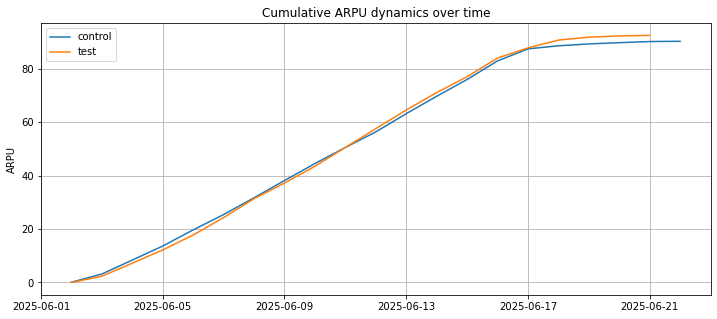

In [35]:
# Prepare data for cumulative ARPU
deposits_clean = deposits.copy()
abt_clean = abt.copy()

deposits_clean['date'] = pd.to_datetime(deposits_clean['event_ts']).dt.date
abt_clean['date'] = pd.to_datetime(abt_clean['event_ts']).dt.date

# Daily deposits by group
daily_deposits = deposits_clean.groupby(['date', 'group'], as_index=False)['amount'].sum()

# Daily unique users
daily_users = abt_clean.groupby(['date', 'group'])['user_id'].nunique().reset_index()
daily_users.columns = ['date', 'group', 'unique_users']

# Merge
daily_data = daily_deposits.merge(daily_users, on=['date', 'group'], how='outer')
daily_data = daily_data.fillna(0)

# Total users per group
total_users_per_group = abt_clean.groupby('group')['user_id'].nunique().reset_index()
total_users_per_group.columns = ['group', 'total_users']
daily_data = daily_data.merge(total_users_per_group, on='group')

# Cumulative ARPU calculation
daily_data['cumulative_deposits'] = daily_data.groupby('group')['amount'].cumsum()
daily_data['cumulative_arpu'] = daily_data['cumulative_deposits'] / daily_data['total_users']
daily_data = daily_data.sort_values(['group', 'date'])

# Plot cumulative ARPU dynamics
plt.figure(figsize=(12, 5))
for group in daily_data['group'].unique():
    group_data = daily_data[daily_data['group'] == group]
    plt.plot(group_data['date'], group_data['cumulative_arpu'], label=group)

plt.title('Cumulative ARPU dynamics over time')
plt.ylabel('ARPU')
plt.legend()
plt.xticks()
plt.grid(True)
plt.show()

**Interim conclusion**

The cumulative ARPU curves for the control and test groups almost полностью overlap, with a slight advantage for the test group. Overall, the difference between the groups is minimal and appears to be statistically insignificant.

**P-value stability over time**

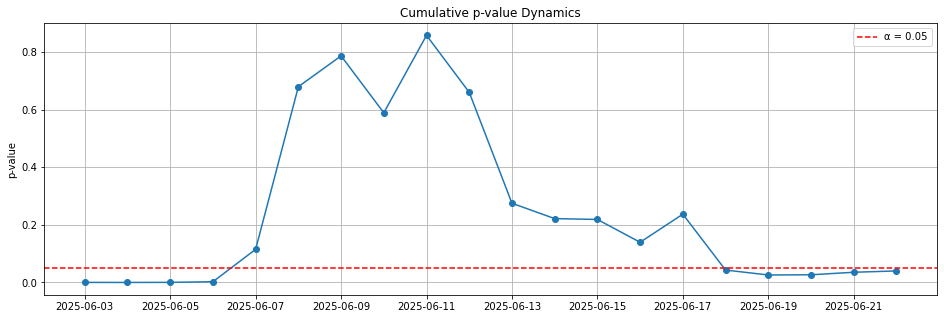

In [36]:
# Convert event timestamps to dates
deposits = abt[abt['event_name'].isin(['first_deposit', 'second_deposit'])].copy()
deposits['event_date'] = pd.to_datetime(deposits['event_ts']).dt.date

# Daily deposit amount per user
daily_user_amount = (deposits.groupby(['event_date', 'user_id', 'group'], as_index=False)['amount'].sum())

# Unique event dates
dates = sorted(daily_user_amount['event_date'].unique())

results = []
for d in dates:
    sample = daily_user_amount[daily_user_amount['event_date'] <= d]
    user_deposits_cum = sample.groupby(['user_id', 'group'], as_index=False)['amount'].sum()
    
    control = user_deposits_cum.loc[user_deposits_cum['group']=='control', 'amount']
    test = user_deposits_cum.loc[user_deposits_cum['group']=='test', 'amount']
    
     # Check minimum sample size
    if len(control) >= 30 and len(test) >= 30:
        stat, pval = stats.ttest_ind(test, control, equal_var=False)
    else:
        pval = np.nan
    
    results.append({'date': d, 'p_value': pval})

pval_df = pd.DataFrame(results)

# Visualization
plt.figure(figsize=(16,5))
plt.plot(pval_df['date'], pval_df['p_value'], marker='o')
plt.axhline(0.05, color='red', linestyle='--', label='α = 0.05')
plt.title('Cumulative p-value Dynamics')
plt.ylabel('p-value')
plt.legend()
plt.grid(True)
plt.show()

**Interim conclusion**

At the beginning of the experiment, the p-value is low and highly unstable, which is expected due to a small accumulated sample size.
In the middle of the experiment, the p-value rises well above the 0.05 threshold, indicating that observed differences between the groups are likely driven by random variation rather than a real effect.

By the end of the experiment, the p-value consistently falls below 0.05 and remains stable, suggesting that the difference between the control and test groups becomes statistically significant over time.

Conclusion: the experimental change has a real and statistically significant impact on ARPU.

**Conversion from registration to first deposit - guardrail metric**

In [37]:
# Total users per group
total_users = abt.groupby('group')['user_id'].nunique().reset_index()
total_users.columns = ['group', 'total_users']

# Users with first deposit
first_deposit_users = abt.query("event_name == 'first_deposit'").groupby('group')['user_id'].nunique().reset_index()
first_deposit_users.columns = ['group', 'deposit_users']

# Merge
conversion = total_users.merge(first_deposit_users, on='group', how='left').fillna(0)

# Conversion
conversion['conversion'] = (conversion['deposit_users'] / conversion['total_users']*100).round(2)

# Test vs control difference
control_conv = conversion.query("group == 'control'")['conversion'].values[0]
test_conv = conversion.query("group == 'test'")['conversion'].values[0]

absolute_diff = test_conv - control_conv
relative_diff = absolute_diff / control_conv * 100

print(conversion)
print(f"Absolute change: {absolute_diff:.2f}")
print(f"Relative change: {relative_diff:.2f}%")

     group  total_users  deposit_users  conversion
0  control         4847           3228       66.60
1     test         4568           2987       65.39
Absolute change: -1.21
Relative change: -1.82%


**Statistical hypotheses**

- H₀ (null hypothesis):
Conversion from registration to first deposit is equal in the control and test groups.

- H₁ (alternative hypothesis):
Conversion from registration to first deposit differs between the control and test groups.

In [38]:
# Proportion Z-test
deposit_user_counts = conversion['deposit_users'].astype(int).values
total_user_counts = conversion['total_users'].astype(int).values

# Z-тест
z_stat, p_value = proportions_ztest(deposit_user_counts, total_user_counts)

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Result: p < 0.05, reject H₀ — the difference is statistically significant")
else:
    print("Result: p ≥ 0.05, fail to reject H₀ — no statistically significant difference")

Z-statistic: 1.2370
P-value: 0.2161
Result: p ≥ 0.05, fail to reject H₀ — no statistically significant difference


**Interim conclusion**

The conversion rate in the test group is slightly lower than in the control group (−1.82%).
However, this difference is not statistically significant (p-value = 0.2161), meaning we fail to reject the null hypothesis of equal conversion rates.

Conclusion: the experiment did not have a statistically significant impact on the guardrail metric.

**Conversion from first to second deposit — Supporting metric 1**

In [39]:
# Users with first deposit
first_deposit_users = abt.query("event_name == 'first_deposit'") \
    .groupby('group')['user_id'].nunique().reset_index()
first_deposit_users.columns = ['group', 'first_deposit_users']

# Users with second deposit
second_deposit_users = abt.query("event_name == 'second_deposit'") \
    .groupby('group')['user_id'].nunique().reset_index()
second_deposit_users.columns = ['group', 'second_deposit_users']

# Merge
conversion2 = first_deposit_users.merge(second_deposit_users, on='group', how='left').fillna(0)

# Conversion rate
conversion2['conversion_fd_to_sd'] = (
    conversion2['second_deposit_users'] / conversion2['first_deposit_users'] * 100
).round(2)

# Differences
control_conv2 = conversion2.query("group == 'control'")['conversion_fd_to_sd'].values[0]
test_conv2 = conversion2.query("group == 'test'")['conversion_fd_to_sd'].values[0]

absolute_diff2 = test_conv2 - control_conv2
relative_diff2 = absolute_diff2 / control_conv2 * 100

print(conversion2)
print(f"Absolute change: {absolute_diff2:.2f}")
print(f"Relative change: {relative_diff2:.2f}%")

     group  first_deposit_users  second_deposit_users  conversion_fd_to_sd
0  control                 3228                   654                20.26
1     test                 2987                   974                32.61
Absolute change: 12.35
Relative change: 60.96%


**Statistical hypotheses**

- H₀ (null hypothesis):
Conversion from first to second deposit is the same in the control and test groups.

- H₁ (alternative hypothesis):
Conversion from first to second deposit differs between the control and test groups.

In [40]:
# Z-test for proportions

second_deposit_counts = conversion2['second_deposit_users'].astype(int).values
first_deposit_counts = conversion2['first_deposit_users'].astype(int).values

# Z-тест
z_stat2, p_value2 = proportions_ztest(count=second_deposit_counts, nobs=first_deposit_counts)

print(f"Z-statistic: {z_stat2:.4f}")
print(f"P-value: {p_value2:.4f}")

if p_value2 < 0.05:
    print("Result: p < 0.05, reject H₀ — the difference is statistically significant")
else:
    print("Result: p ≥ 0.05, fail to reject H₀ — no statistically significant difference")

Z-statistic: -11.0612
P-value: 0.0000
Result: p < 0.05, reject H₀ — the difference is statistically significant


**Interim conclusion**

The conversion from the first to the second deposit differs substantially between the test and control groups.
In relative terms, the increase is nearly 61%, and the Z-test confirms that the difference is statistically significant.

Conclusion: the experiment is successful in terms of increasing user retention and loyalty. Users in the test group proceed to a second deposit more than twice as often as users in the control group.

**Average total deposit amount per user with at least one deposit - Supporting metric 2**

In [41]:
# Filter deposits
deposits = abt.query("event_name in ['first_deposit', 'second_deposit', 'deposit']")

# Total deposit amount per user
user_deposit_sum = deposits.groupby(['group', 'user_id'])['amount'].sum().reset_index()

# Average deposit amount per depositing user
avg_deposit_per_user = user_deposit_sum.groupby('group')['amount'].mean().reset_index()
avg_deposit_per_user.columns = ['group', 'avg_deposit_sum']

# Differences
control_mean = avg_deposit_per_user.query("group == 'control'")['avg_deposit_sum'].values[0]
test_mean = avg_deposit_per_user.query("group == 'test'")['avg_deposit_sum'].values[0]

absolute_diff3 = test_mean - control_mean
relative_diff3 = absolute_diff3 / control_mean * 100

print(avg_deposit_per_user)
print(f"Absolute change: {absolute_diff3:.2f}")
print(f"Relative change: {relative_diff3:.2f}%")

     group  avg_deposit_sum
0  control       135.500000
1     test       141.399732
Absolute change: 5.90
Relative change: 4.35%


**Statistical hypotheses**

- H₀ (null hypothesis):
The average total deposit amount per user is the same in the control and test groups.

- H₁ (alternative hypothesis):
The average total deposit amount per user differs between the control and test groups.

In [42]:
# Welch’s t-test
control_values = user_deposit_sum.query("group == 'control'")['amount']
test_values = user_deposit_sum.query("group == 'test'")['amount']

t_stat, p_value = ttest_ind(test_values, control_values, equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The difference is statistically significant (p < 0.05).")
else:
    print("The difference is NOT statistically significant (p ≥ 0.05).")

T-statistic: 2.0540
P-value: 0.0400
The difference is statistically significant (p < 0.05).


**Interim conclusion**

Among users who made at least one deposit, the average total deposit amount per user in the test group is 4.35% higher than in the control group.
This difference is statistically significant, although the magnitude of the effect is relatively small.

Interpretation: the experiment successfully attracts more users to make a second deposit, but these additional users tend to deposit smaller amounts on average.

---
#### 4. Analysis of changes in deposit amount per paying user

The new feature may have affected user behavior in different ways.

- Users who previously deposited small amounts may have become more cautious, reduced their investments, or stopped depositing altogether. This would be reflected in a decline of the 25th percentile of total deposits in the test group.

- Users who tend to make larger investments may have become more engaged with the product and started depositing larger amounts. This would be reflected in an increase of the 75th percentile.

Using a bootstrap approach, we compare the differences in percentiles (25th, 50th, and 75th) of the total deposit amount per paying user between the control and test groups.

In [43]:
np.random.seed(341)

control = user_deposit_sum.query("group == 'control'")['amount'].values
test = user_deposit_sum.query("group == 'test'")['amount'].values

n_iterations = 1000
percentiles = [25, 50, 75]
boot_diffs = {p: [] for p in percentiles}

for _ in range(n_iterations):
    boot_control = np.random.choice(control, size=len(control), replace=True)
    boot_test = np.random.choice(test, size=len(test), replace=True)
    
    for p in percentiles:
        c_val = np.percentile(boot_control, p)
        t_val = np.percentile(boot_test, p)
        boot_diffs[p].append(t_val - c_val)

# Confidence intervals
for p in percentiles:
    diffs = np.array(boot_diffs[p])
    ci = np.percentile(diffs, [2.5, 97.5])
    c_val = np.percentile(control, p)
    t_val = np.percentile(test, p)
    print(f"{p}th percentile:")
    print(
        f"  Control: {c_val:.2f}, Test: {t_val:.2f}, "
        f"Difference: {np.mean(diffs):.2f}, "
        f"95% CI: [{ci[0]:.2f}, {ci[1]:.2f}]"
    )

25th percentile:
  Control: 95.00, Test: 48.00, Difference: -46.86, 95% CI: [-50.00, -44.00]
50th percentile:
  Control: 118.00, Test: 94.00, Difference: -23.28, 95% CI: [-27.00, -19.00]
75th percentile:
  Control: 159.00, Test: 179.50, Difference: 20.38, 95% CI: [11.00, 30.00]


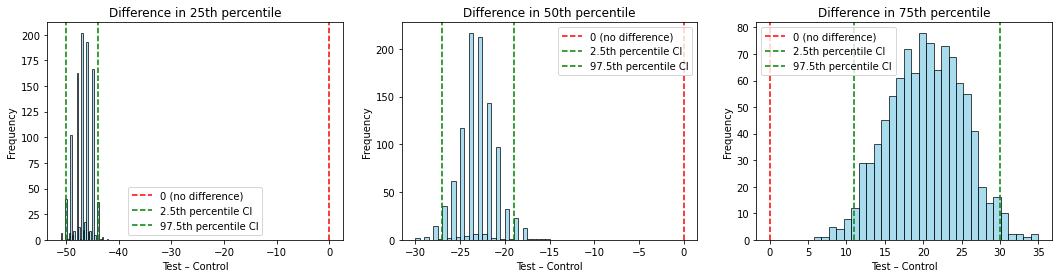

In [44]:
# Visualization

percentiles = [25, 50, 75]

fig, axes = plt.subplots(1, len(percentiles), figsize=(18, 4))

for i, p in enumerate(percentiles):
    diffs = np.array(boot_diffs[p])
    ci = np.percentile(diffs, [2.5, 97.5])
    
    axes[i].hist(diffs, bins=30, alpha=0.7, color="skyblue", edgecolor="black")
    axes[i].axvline(0, color="red", linestyle="--", label="0 (no difference)")
    axes[i].axvline(ci[0], color="green", linestyle="--", label="2.5th percentile CI")
    axes[i].axvline(ci[1], color="green", linestyle="--", label="97.5th percentile CI")
    
    axes[i].set_title(f"Difference in {p}th percentile")
    axes[i].set_xlabel("Test – Control")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

plt.show()

| Percentile        | Control | Test   | Difference (Test − Control) | 95% CI           | Statistical Significance | Interpretation                                                                                      |
| ----------------- | ------- | ------ | --------------------------- | ---------------- | ------------------------ | --------------------------------------------------------------------------------------------------- |
| **25th**          | 95.00   | 48.00  | **−46.86**                  | [−50.00, −44.00] | ✅ Significant            | Lower-segment users deposit almost **50% less**, confirming increased caution among small investors |
| **50th (Median)** | 118.00  | 94.00  | **−23.28**                  | [−27.00, −19.00] | ✅ Significant            | Typical users reduced deposit sizes, indicating higher perceived risk                               |
| **75th**          | 159.00  | 179.50 | **+20.38**                  | [11.00, 30.00]   | ✅ Significant            | High-value users increased deposits, showing stronger engagement                                    |


**Interim conclusion**

The decline in the median may be related to the fact that the detailed onboarding had a restraining effect on a portion of users with a medium level of engagement. These users may have perceived the new feature as a signal of increased risk. As a result, they began to make deposits less frequently or reduced their deposit amounts, which ultimately led to a decrease in the median value.

---
### 5. Conclusions

Based on the conducted A/B test, the following conclusions can be drawn:

- **Deposit risk levels**

The new feature had a positive impact in this area: users in the test group purchased both high-risk and low-risk assets significantly more often than users in the control group.

- **Key metric - ARPU**

According to the key metric, ARPU (the average total deposit amount per user, including all users who installed the app or opened the web version), the difference between the control and test groups was only 2.5% in favor of the test group. However, this difference is not statistically significant, so we conclude that the average revenue per user did not change.

- **Barrier metric - conversion to first deposit**

The conversion rate to the first deposit decreased by 1.82% in the test group compared to the control group. This decrease is not statistically significant, which indicates that the new feature did not discourage users.

- **Supporting metrics**

The conversion rate from the first deposit to the second deposit is 60% higher in the test group, indicating that users in the test group return and make repeat deposits more often.
The average total deposit amount among active users in the test group increased by 4.35%, and this increase is statistically significant.

- **Impact on deposit amounts**

The new feature led to a polarization of user behavior:
small investors started depositing even less, medium-level users also reduced their deposit amounts, while large investors became more engaged and increased their investments. The hypothesis that the new onboarding improves financial literacy has therefore been confirmed.

**Overall conclusion**

The new feature demonstrates its effectiveness in increasing repeat investments and engagement among active users, especially in high-risk scenarios. At the same time, it is important to account for the potential decline in initial conversion and to work on balancing user education with motivation. With continued optimization, it is possible to improve retention and increase average revenue per user.